In [1]:
from skyfield.api import load, EarthSatellite, Topos
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta, timezone
import pytz

In [2]:
def get_sat_tle_data(tle_path):
    sat_data = {}
    with open(tle_path, 'r') as f:
        lines = f.readlines()
    # Process 3 lines at a time (name + two TLE lines)
    for i in range(0, len(lines), 3):
        if i + 2 >= len(lines):
            break
        sat_name = lines[i].strip()
        tle_line1 = lines[i + 1].strip()
        # NORAD ID is characters 3-7 in first TLE line
        tle_line2 = lines[i + 2].strip()
        sat_data[sat_name] = [tle_line1, tle_line2]
    return sat_data

# Dynamic Starlink Filtering without Greedy Filter

In [36]:
# --- Configuration ---
SOURCE_TLE_FILE = './tle/Starlink0.tle' # Using the user's provided file for now
OUTPUT_TLE_FILE = './tle/dynamic_filtered_starlink.tle' # Output for the selected sats

# Target Location (Inman, Kansas)
TARGET_LAT = 38.2
TARGET_LON = -97.8

# Simulation Window (Define Start Time in UTC or Local with Timezone)
# Example: Start a few minutes from now
# MDT is UTC-6
local_tz = pytz.timezone('America/Los_Angeles') # PDT
sim_start_local = local_tz.localize(datetime(2022, 9, 14, 7, 30, 0)) # 7:30 AM PDT
sim_start_utc = sim_start_local.astimezone(pytz.utc)
SIM_DURATION_MINUTES = 60 * 24  # 24 hours
sim_end_utc = sim_start_utc + timedelta(minutes=SIM_DURATION_MINUTES)

# Visibility Parameters
MIN_ELEVATION_DEG = 25.0 # Minimum elevation for visibility
CHECK_INTERVAL_SECONDS = 300 # How often to check visibility within the window
# NOTE: With 750 nodes, we can achieve 100% uptime for the entire US
# NOTE: With 500 nodes, we can achieve 100% uptime in specific regions on US
# NOTE: With 300 nodes, we can achieve only 95% uptime for a single region on US
# NOTE: With 150 nodes, we can achieve only 90% uptime for Montana
# NOTE: With 100 nodes, we can achieve only 60-80% uptime for a single region on US
MAX_SATELLITES_TO_SELECT = 750

# --- Main Script ---
ts = load.timescale()

# Load all candidate satellites and their original TLE lines
all_sat_data = get_sat_tle_data(SOURCE_TLE_FILE)
candidate_satellites = load.tle_file(SOURCE_TLE_FILE)
print(f"Loaded {len(all_sat_data)} candidate satellites from {SOURCE_TLE_FILE}")

# --- Dynamic Filtering Logic ---
observer = Topos(latitude_degrees=TARGET_LAT, longitude_degrees=TARGET_LON)

# 1. Identify potentially useful satellites and their visibility intervals
potentially_visible = []
time_points_to_check = []
current_check_time = sim_start_utc
while current_check_time <= sim_end_utc:
    time_points_to_check.append(ts.from_datetime(current_check_time))
    current_check_time += timedelta(seconds=CHECK_INTERVAL_SECONDS)

print(f"\nChecking visibility for {len(candidate_satellites)} satellites over {SIM_DURATION_MINUTES} minutes...")

for sat in candidate_satellites:
    visibility_intervals = []
    is_currently_visible = False
    interval_start_time = None

    for t in time_points_to_check:
        observer_at_t = observer.at(t)
        difference = sat.at(t) - observer_at_t
        alt, az, distance = difference.altaz()
        visible_now = alt.degrees >= MIN_ELEVATION_DEG

        if visible_now and not is_currently_visible:
            # Start of a new visibility interval
            is_currently_visible = True
            interval_start_time = t
        elif not visible_now and is_currently_visible:
            # End of a visibility interval
            is_currently_visible = False
            # Record interval (start_time, end_time) - end time is the current time step
            visibility_intervals.append((interval_start_time, t))
            interval_start_time = None

    # If still visible at the end of the window, close the interval
    if is_currently_visible:
        visibility_intervals.append((interval_start_time, time_points_to_check[-1]))

    if visibility_intervals:
        potentially_visible.append({'sat': sat, 'intervals': visibility_intervals})

print(f"Found {len(potentially_visible)} potentially visible satellites during the window.")


# 2. Select subset for max coverage (Greedy Approach)
selected_satellites_data = [] # Store dicts {'sat': obj, 'start': t, 'end': t}
sorted_potentially_visible = sorted(potentially_visible, key=lambda x: len(x['intervals']), reverse=True)
selected_satellites_data = sorted_potentially_visible[:MAX_SATELLITES_TO_SELECT]

# 3. Save the selected subset TLEs
print(f"\nSaving selected satellite TLEs to {OUTPUT_TLE_FILE}")
selected_count = 0
with open(OUTPUT_TLE_FILE, 'w') as f:
    for sat_data_entry in selected_satellites_data:
        sat_obj = sat_data_entry['sat']
        sat_name = sat_obj.name
        if sat_name in all_sat_data:
            f.write(f"{sat_name}\n")
            f.write(f"{all_sat_data[sat_name][0]}\n")
            f.write(f"{all_sat_data[sat_name][1]}\n")
            selected_count += 1
        else:
            print(f"Error: Could not find original TLE data for selected satellite {sat_name}")

print(f"Successfully saved {selected_count} TLEs.")

Loaded 2992 candidate satellites from ./tle/Starlink0.tle

Checking visibility for 3023 satellites over 1440 minutes...
Found 2833 potentially visible satellites during the window.

Saving selected satellite TLEs to ./tle/dynamic_filtered_starlink.tle
Successfully saved 750 TLEs.


# Coverage Plots

In [37]:
# Load timescale and TLEs
ts = load.timescale()
tle_file = './tle/dynamic_filtered_starlink.tle'  # Replace with your TLE file
satellites = load.tle_file(tle_file)

# Define time range (24 hours)
start_time = ts.utc(2022, 9, 14, 12, 0, 0)
end_time = ts.utc(2022, 9, 15, 12, 0, 0)
time_step = timedelta(minutes=5)  # 5 minutes of resolution
times = ts.utc([start_time.utc_datetime() + i * time_step for i in range(int((end_time.utc_datetime() - start_time.utc_datetime()).total_seconds() / time_step.total_seconds()))])

# Define North America grid
latitudes = np.arange(15, 61, 4)  # 4 degrees of resolution
longitudes = np.arange(-130, -59, 4)  # 4 degrees of resolution
grid_lat, grid_lon = np.meshgrid(latitudes, longitudes, indexing='ij')  # Changed indexing to 'ij'
coverage = np.zeros_like(grid_lat, dtype=int)
min_elevation = 25

# Compute coverage
for t in times:
    # Precompute satellite subpoints for all satellites at this time
    subpoints = [sat.at(t).subpoint() for sat in satellites]
    sat_lats = np.array([sp.latitude.degrees for sp in subpoints])
    sat_lons = np.array([sp.longitude.degrees for sp in subpoints])

    for i, lat in enumerate(latitudes):
        for j, lon in enumerate(longitudes):
            # Filter satellites: only check those within ~15° (~1000 km footprint)
            dist = np.sqrt((sat_lats - lat)**2 + (sat_lons - lon)**2)
            nearby = dist < 15  # Approximate visibility cone radius
            if not np.any(nearby):
                continue  # Skip if no satellites are nearby

            station = Topos(latitude_degrees=lat, longitude_degrees=lon)
            visible = 0
            for k, sat in enumerate(satellites):
                if not nearby[k]:
                    continue
                difference = sat - station
                topocentric = difference.at(t)
                alt, az, dist = topocentric.altaz()
                if alt.degrees > min_elevation:
                    visible += 1
            if visible > 0:
                coverage[i,j] += 1

# Normalize to percentage
coverage_percent = (coverage / len(times)) * 100

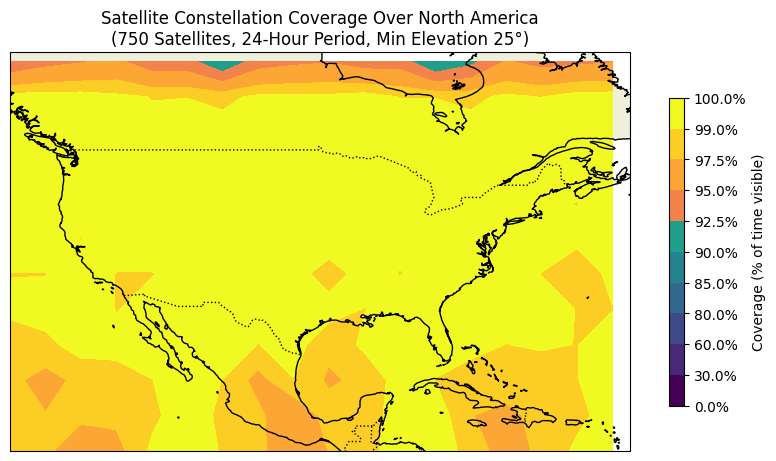

Percentage of North America with >99% coverage: 60.19%


In [38]:
# Plot coverage over NA
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, -60, 15, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
# Create custom levels and colors to emphasize 90% and above
levels = [0, 30, 60, 80, 85, 90, 92.5, 95, 97.5, 99, 100]
colors = plt.cm.viridis(np.linspace(0, 1, len(levels)-1))
# Make the last few colors brighter/more distinct
colors[-4:] = plt.cm.plasma(np.linspace(0.7, 1, 4))

cf = ax.contourf(longitudes, latitudes, coverage_percent, 
                 levels=levels, colors=colors, transform=ccrs.PlateCarree())
plt.colorbar(cf, ax=ax, label='Coverage (% of time visible)', shrink=0.5, 
            ticks=levels, format='%.1f%%')
plt.title(f'Satellite Constellation Coverage Over North America\n({len(satellites)} Satellites, 24-Hour Period, Min Elevation 25°)')
plt.show()

# Check adequacy
adequate_coverage = np.mean(coverage_percent > 99) * 100
print(f"Percentage of North America with >99% coverage: {adequate_coverage:.2f}%")

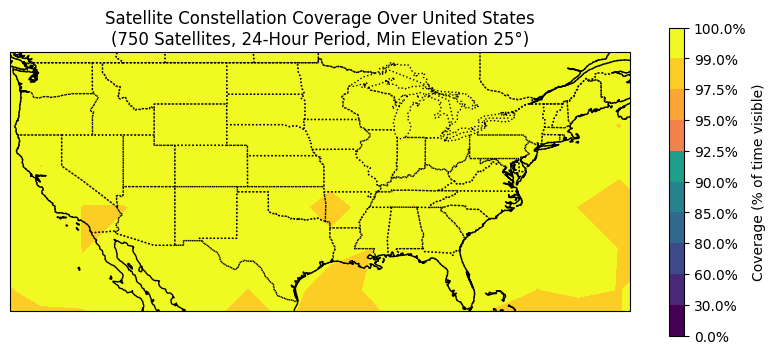

Percentage of North America with >99% coverage: 60.19%


In [39]:
# Plot coverage over USA
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -65, 25, 50], crs=ccrs.PlateCarree())  # Adjusted to continental USA bounds
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')  # Added state borders

# Create custom levels and colors to emphasize 90% and above
levels = [0, 30, 60, 80, 85, 90, 92.5, 95, 97.5, 99, 100]
colors = plt.cm.viridis(np.linspace(0, 1, len(levels)-1))
# Make the last few colors brighter/more distinct
colors[-4:] = plt.cm.plasma(np.linspace(0.7, 1, 4))

cf = ax.contourf(longitudes, latitudes, coverage_percent, 
                 levels=levels, colors=colors, transform=ccrs.PlateCarree())
plt.colorbar(cf, ax=ax, label='Coverage (% of time visible)', shrink=0.5, 
            ticks=levels, format='%.1f%%')
plt.title(f'Satellite Constellation Coverage Over United States\n({len(satellites)} Satellites, 24-Hour Period, Min Elevation 25°)')
plt.show()

# Check adequacy
adequate_coverage = np.mean(coverage_percent > 99) * 100
print(f"Percentage of North America with >99% coverage: {adequate_coverage:.2f}%")